In [1]:
import sys
import os 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from datetime import datetime
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from metpy.units import units  # Use MetPy's unit registry
# Customized functions
sys.path.append(os.path.expanduser('/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/transfomer'))
# Import necessary components from the updated NN
from NNstruct_v9 import mask_slices, MultivariableLocalTransformerWithChannelMixer, extract_local_window, restore_output_to_original_shape, train_model_multivariate

sys.path.append(os.path.expanduser('/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/functions'))
from data_processing import process_files, load_daily_data
# Define directories and parameters
data_dir = '/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/data/2016/'
start_UT = 0
end_UT = 8
dt = 0.1
nepoch = int((end_UT - start_UT) / dt)

# Create output directory
base_dir = '/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/Results/newrun/'
current_date = datetime.now().strftime('%m_%d_%y')
output_dir = os.path.join(base_dir, current_date)
os.makedirs(output_dir, exist_ok=True)
print(f"Results will be saved in: {output_dir}")

# Load data files
all_files = [f for f in os.listdir(data_dir) if f.endswith('.dat') and '15min_1.0km_60s' in f]
random.shuffle(all_files)

# Split into train and test sets
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)

# Process training and test data
train_data = process_files(train_files, start_UT, end_UT, data_dir)
test_data = process_files(test_files, start_UT, end_UT, data_dir)

# Print data shapes for verification
print("Training Data Shapes:")
for key in train_data.keys():
    print(f"Shape of {key}: {train_data[key].shape}")

print("Test Data Shapes:")
for key in test_data.keys():
    print(f"Shape of {key}: {test_data[key].shape}")

# Define the multivariable transformer model
# Set device
device = torch.device("mps" if torch.has_mps else "cpu")
# Model hyperparameters
batch_size = 16
time_steps = 80
altitude_levels = 71
input_dim = 3   # Sodium density, wind, and temperature are 3-dimensional inputs
d_model = 64    # Reduced embedding dimension
nhead = 8       # Attention heads
num_layers = 4  # Transformer layers
dim_feedforward = 256  # Feedforward layer size
num_epochs = 300  # Number of epochs
window_size = 3
mask_ratio = 0.8
step_size = 1
base_weight = 1
lambda_smooth = 1

# Initialize the multivariable transformer model
model = MultivariableLocalTransformerWithChannelMixer(
    input_dim=input_dim,    # Multivariable inputs
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    window_size=window_size  # Assuming a 3x3 window size
).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Variables to load (e.g., Sodium density, Wind, Temperature)
variables = ["Na Density (cm^(-3))", "Vertical Wind (m/s)", "Temperature (K)"]
# Train the multivariable model using the local windows approach
train_model_multivariate(
    model, 
    train_files, 
    test_files, 
    data_dir, 
    variables,        # Variables to process
    optimizer, 
    num_epochs, 
    device, 
    batch_size, 
    start_UT, 
    end_UT, 
    output_dir,
    window_size,
    mask_ratio,
    time_steps, 
    altitude_levels,
    step_size, 
    base_weight, 
    lambda_smooth
)

Results will be saved in: /Users/huj7/Desktop/ERAU/MVI-2D-multivariable/Results/newrun/10_18_24
Training Data Shapes:
Shape of Na Density (cm^(-3)): (71, 1840)
Shape of Na Density Error (cm^(-3)): (71, 1840)
Shape of Temperature (K): (71, 1840)
Shape of Temperature Error (K): (71, 1840)
Shape of Vertical Wind (m/s): (71, 1840)
Shape of Vertical Wind Error (m/s): (71, 1840)
Shape of Zonal Wind (m/s): (71, 1840)
Shape of Zonal Wind Error (m/s): (71, 1840)
Shape of Meridional Wind (m/s): (71, 1840)
Shape of Meridional Wind Error (m/s): (71, 1840)
Shape of YYYYMMDD_hhmm: (1840,)
Shape of Altitudes [km]: (71,)
Test Data Shapes:
Shape of Na Density (cm^(-3)): (71, 480)
Shape of Na Density Error (cm^(-3)): (71, 480)
Shape of Temperature (K): (71, 480)
Shape of Temperature Error (K): (71, 480)
Shape of Vertical Wind (m/s): (71, 480)
Shape of Vertical Wind Error (m/s): (71, 480)
Shape of Zonal Wind (m/s): (71, 480)
Shape of Zonal Wind Error (m/s): (71, 480)
Shape of Meridional Wind (m/s): (71, 

/var/folders/2c/2k10l7w17539zwm_06lqntvh0000gq/T/ipykernel_27790/1260158969.py:56: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cpu")



Starting epoch 1/300
> /Users/huj7/Desktop/ERAU/MVI-2D-multivariable/functions/P_var.py(89)calculate_potential_temperature()
     87         pdb.set_trace()
     88         # Calculate pressure in Pascals using the ideal gas law
---> 89         pressure = calculate_pressure(total_density_with_units, temperature)
     90 
     91         # Convert pressure from Pascals to hPa for use in MetPy



DimensionalityError: Cannot convert from 'kilogram * joule / meter ** 6' ([mass] ** 2 / [length] ** 4 / [time] ** 2) to 'hectopascal' ([mass] / [length] / [time] ** 2)

In [1]:
import sys
import os 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from datetime import datetime
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Customized functions
sys.path.append(os.path.expanduser('/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/transfomer'))
# Import necessary components from the updated NN
from NNstruct_v9 import mask_slices, MultivariableLocalTransformerWithChannelMixer, extract_local_window, restore_output_to_original_shape, train_model_multivariate

sys.path.append(os.path.expanduser('/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/functions'))
from data_processing import process_files, load_daily_data
# Define directories and parameters
data_dir = '/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/data/2016/'
start_UT = 0
end_UT = 8
dt = 0.1
nepoch = int((end_UT - start_UT) / dt)

# Create output directory
base_dir = '/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/Results/newrun/'
current_date = datetime.now().strftime('%m_%d_%y')
output_dir = os.path.join(base_dir, current_date)
os.makedirs(output_dir, exist_ok=True)
print(f"Results will be saved in: {output_dir}")

# Load data files
all_files = [f for f in os.listdir(data_dir) if f.endswith('.dat') and '15min_1.0km_60s' in f]
random.shuffle(all_files)

# Split into train and test sets
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)

# Process training and test data
train_data = process_files(train_files, start_UT, end_UT, data_dir)
test_data = process_files(test_files, start_UT, end_UT, data_dir)

# Print data shapes for verification
print("Training Data Shapes:")
for key in train_data.keys():
    print(f"Shape of {key}: {train_data[key].shape}")

print("Test Data Shapes:")
for key in test_data.keys():
    print(f"Shape of {key}: {test_data[key].shape}")

# Define the multivariable transformer model

# Set device
device = torch.device("mps" if torch.has_mps else "cpu")

# Model hyperparameters
batch_size = 16
time_steps = 80
altitude_levels = 71
input_dim = 3   # Sodium density, wind, and temperature are 3-dimensional inputs
d_model = 64    # Reduced embedding dimension
nhead = 8       # Attention heads
num_layers = 4  # Transformer layers
dim_feedforward = 256  # Feedforward layer size
num_epochs = 300  # Number of epochs
window_size = 3
mask_ratio = 0.8
step_size = 1
base_weight = 1
lambda_smooth = 1

# Initialize the multivariable transformer model
model = MultivariableLocalTransformerWithChannelMixer(
    input_dim=input_dim,    # Multivariable inputs
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    window_size=window_size  # Assuming a 3x3 window size
).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Variables to load (e.g., Sodium density, Wind, Temperature)
variables = ["Na Density (cm^(-3))", "Vertical Wind (m/s)", "Temperature (K)"]

# Train the multivariable model using the local windows approach
train_model_multivariate(
    model, 
    train_files, 
    test_files, 
    data_dir, 
    variables,        # Variables to process
    optimizer, 
    num_epochs, 
    device, 
    batch_size, 
    start_UT, 
    end_UT, 
    output_dir,
    window_size,
    mask_ratio,
    time_steps, 
    altitude_levels,
    step_size, 
    base_weight, 
    lambda_smooth
)

Results will be saved in: /Users/huj7/Desktop/ERAU/MVI-2D-multivariable/Results/newrun/10_18_24
Training Data Shapes:
Shape of Na Density (cm^(-3)): (71, 1840)
Shape of Na Density Error (cm^(-3)): (71, 1840)
Shape of Temperature (K): (71, 1840)
Shape of Temperature Error (K): (71, 1840)
Shape of Vertical Wind (m/s): (71, 1840)
Shape of Vertical Wind Error (m/s): (71, 1840)
Shape of Zonal Wind (m/s): (71, 1840)
Shape of Zonal Wind Error (m/s): (71, 1840)
Shape of Meridional Wind (m/s): (71, 1840)
Shape of Meridional Wind Error (m/s): (71, 1840)
Shape of YYYYMMDD_hhmm: (1840,)
Shape of Altitudes [km]: (71,)
Test Data Shapes:
Shape of Na Density (cm^(-3)): (71, 480)
Shape of Na Density Error (cm^(-3)): (71, 480)
Shape of Temperature (K): (71, 480)
Shape of Temperature Error (K): (71, 480)
Shape of Vertical Wind (m/s): (71, 480)
Shape of Vertical Wind Error (m/s): (71, 480)
Shape of Zonal Wind (m/s): (71, 480)
Shape of Zonal Wind Error (m/s): (71, 480)
Shape of Meridional Wind (m/s): (71, 

/var/folders/2c/2k10l7w17539zwm_06lqntvh0000gq/T/ipykernel_14273/3462100529.py:56: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cpu")



Starting epoch 1/300
> /Users/huj7/Desktop/ERAU/MVI-2D-multivariable/functions/P_var.py(101)calculate_buoyancy_frequency_sqrd()
     99     import pdb
    100     pdb.set_trace()
--> 101     dtheta_dz = np.gradient(np.squeeze(potential_temp), alt_meters)  # Vertical gradient of potential temperature
    102 
    103     # Compute buoyancy frequency N

(5680,)
array([0.00031253, 0.00031965, 0.00032697, ..., 0.00204556, 0.00213006,
       0.00221749])
[80000.0 80500.0 81000.0 81500.0 82000.0 82500.0 83000.0 83500.0 84000.0 84500.0 85000.0 85500.0 86000.0 86500.0 87000.0 87500.0 88000.0 88500.0 89000.0 89500.0 90000.0 90500.0 91000.0 91500.0 92000.0 92500.0 93000.0 93500.0 94000.0 94500.0 95000.0 95500.0 96000.0 96500.0 97000.0 97500.0 98000.0 98500.0 99000.0 99500.0 100000.0 100500.0 101000.0 101500.0 102000.0 102500.0 103000.0 103500.0 104000.0 104500.0 105000.0 105500.0 106000.0 106500.0 107000.0 107500.0 108000.0 108500.0 109000.0 109500.0 110000.0 110500.0 111000.0 111500.0 112000.0

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from NNstruct_v9 import load_multivariate_data, plot_and_save_2d_comparison, mask_slices, MultivariableLocalTransformerWithChannelMixer, extract_local_window, restore_output_to_original_shape

def impute_missing_data(
    model, 
    data_dir, 
    imputation_files, 
    variables, 
    device, 
    batch_size, 
    start_UT, 
    end_UT, 
    output_dir, 
    window_size, 
    time_steps, 
    altitude_levels, 
    step_size
):
    """
    Function to impute missing data using a pre-trained model.

    Arguments:
    - model: The pre-trained model for imputation.
    - data_dir: Directory containing the data.
    - imputation_files: List of files to impute.
    - variables: List of variables (e.g., sodium density, wind, temperature).
    - device: Device (e.g., 'cuda' or 'cpu').
    - batch_size: Batch size for the DataLoader.
    - start_UT, end_UT: Start and end times for extracting the data.
    - output_dir: Directory to save imputed results.
    - window_size: The size of the window for local extraction.
    - time_steps, altitude_levels: Time and altitude dimensions of the data.
    - step_size: Step size for the sliding window.

    Returns:
    - imputed_data: The data with imputed values filled in.
    """
    model.eval()
    imputed_results = []

    with torch.no_grad():
        for index, filename in enumerate(imputation_files):
            # Load the data from the file
            val_data, scalers = load_multivariate_data(data_dir, [filename], start_UT, end_UT, variables)
            
            # Mask NaN values in the validation data
            mask_val = torch.isnan(val_data).float().to(device)
            mask_val = 1.0 - mask_val
            val_data = torch.nan_to_num(val_data, nan=0.0).to(device)
            target_val_data = val_data.clone()

            # Create the DataLoader for batch processing
            val_dataset = TensorDataset(val_data, target_val_data, mask_val)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            for batch_idx, (batch_data, batch_target, batch_mask) in enumerate(val_loader):
                batch_data, batch_target, batch_mask = batch_data.to(device), batch_target.to(device), batch_mask.to(device)

                # Apply the mask to get the masked data
                masked_data = batch_data * batch_mask
                
                # Extract local windows and their masks
                local_windows, local_masks = extract_local_window(masked_data, batch_mask, window_size, step_size)
                local_windows_orig, local_masks_orig = extract_local_window(batch_data, batch_mask, window_size, step_size)
                
                # Perform the imputation by passing through the model
                output = model(local_windows)
                
                # Restore the output to its original shape
                restored_output = restore_output_to_original_shape(output, batch_data.shape[0], time_steps, altitude_levels, window_size, step_size)

                # Optionally plot and save comparison images for visualization
                plot_and_save_2d_comparison(restored_output, masked_data, batch_data, index, output_dir, time_steps, altitude_levels, batch_idx, variables, 'imputation')

                # Collect the restored output for further processing
                imputed_results.append(restored_output.cpu())

    # Combine all the imputed results into a single tensor
    imputed_data = torch.cat(imputed_results, dim=0)

    return imputed_data


ModuleNotFoundError: No module named 'NNstruct_v9'

/var/folders/2c/2k10l7w17539zwm_06lqntvh0000gq/T/ipykernel_33577/1662701075.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/Users/huj7/Desktop

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


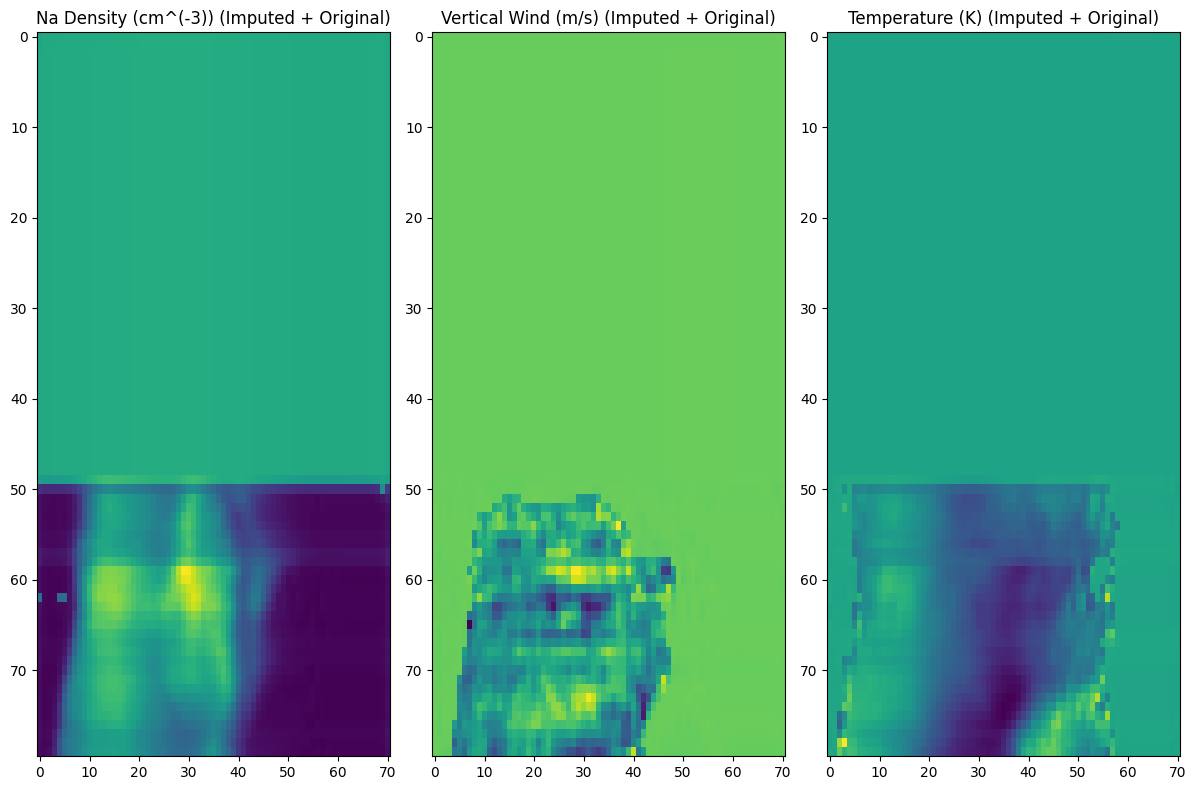

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  ...

  [[1. 0. 1.]
   [1. 0. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 1.]
   [1. 0. 1.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 1.]
   [1. 0. 1.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


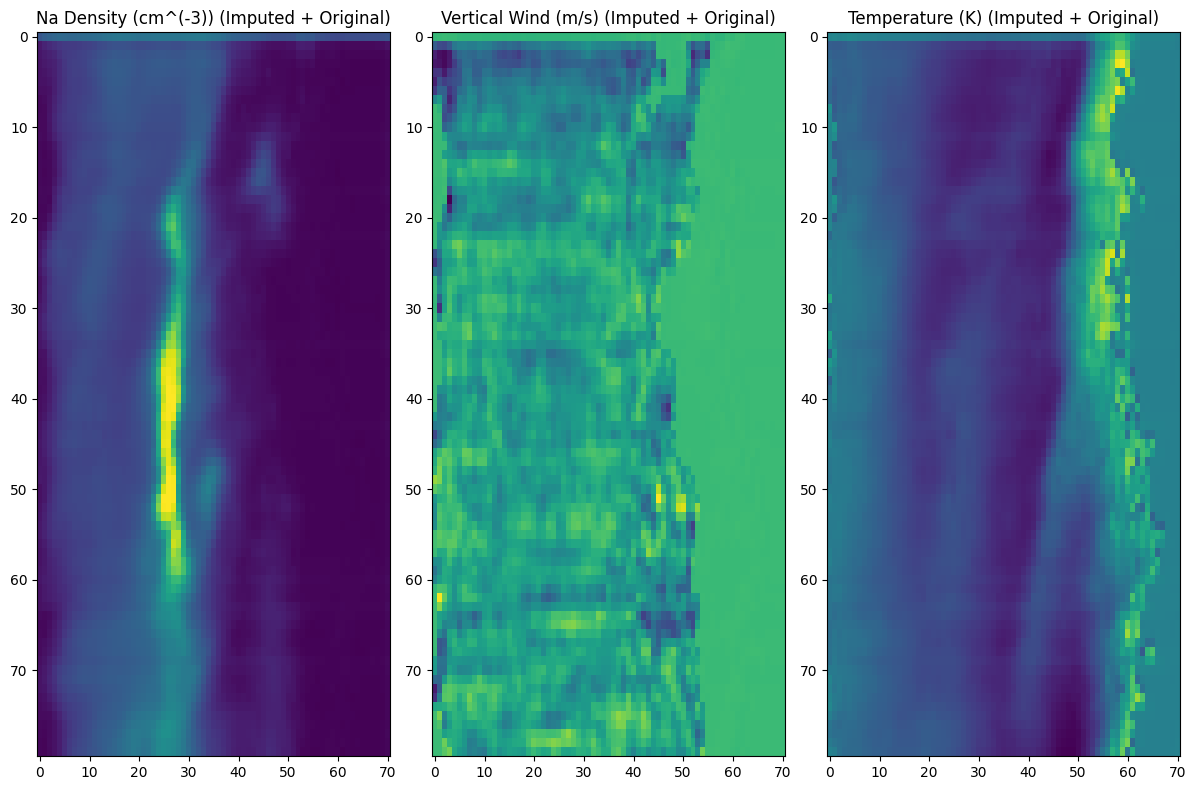

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 1.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]


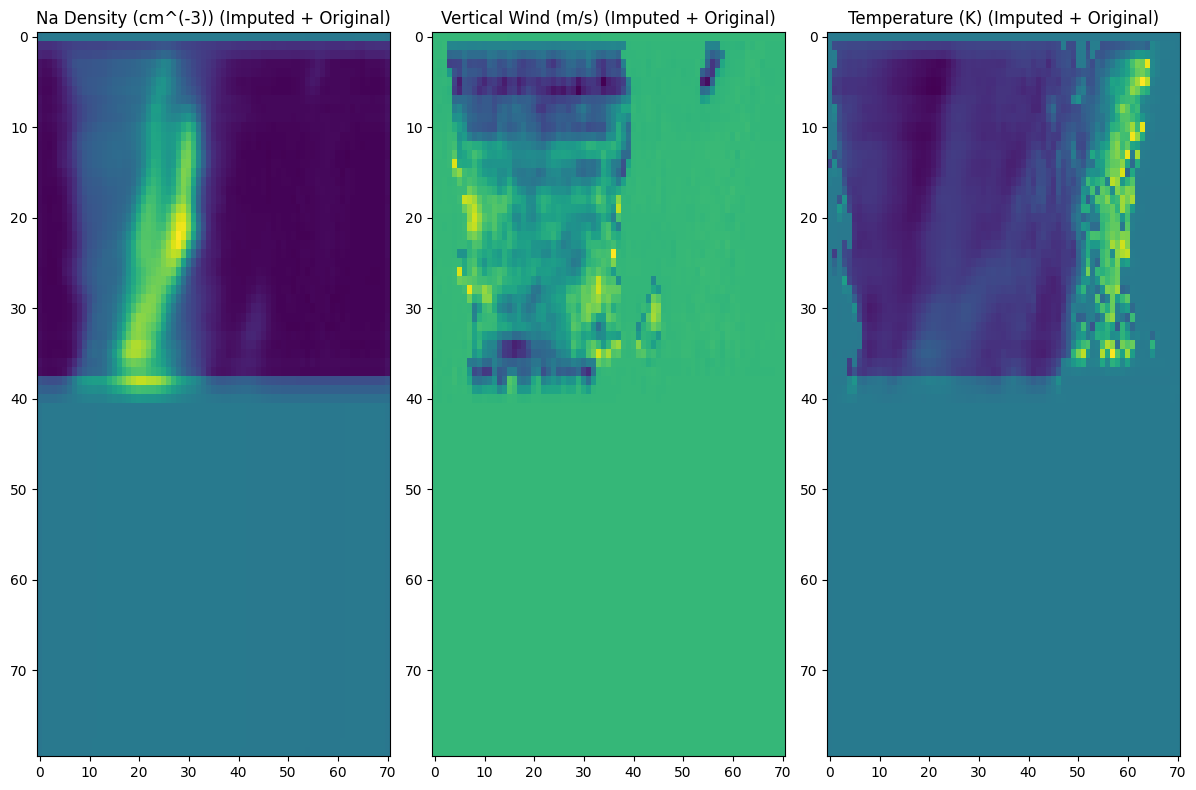

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]


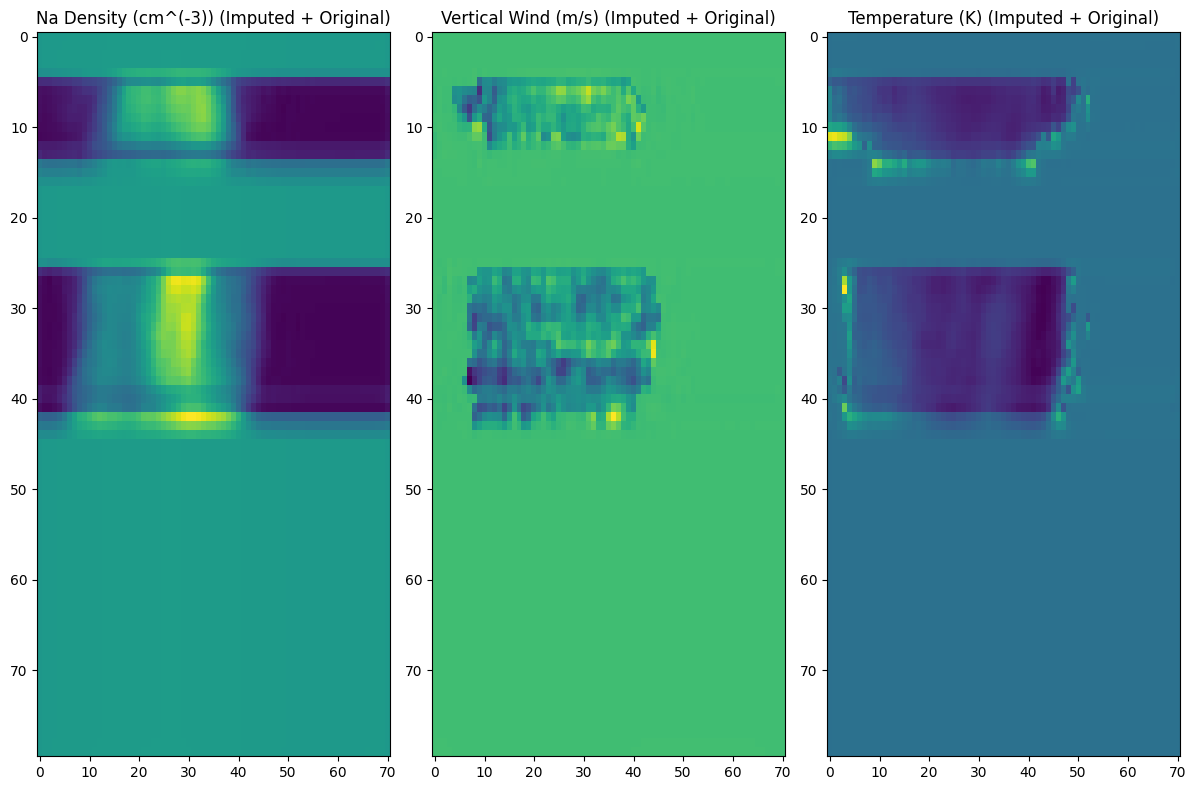

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 0. 1.]
   [1. 0. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 1.]
   [1. 0. 1.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


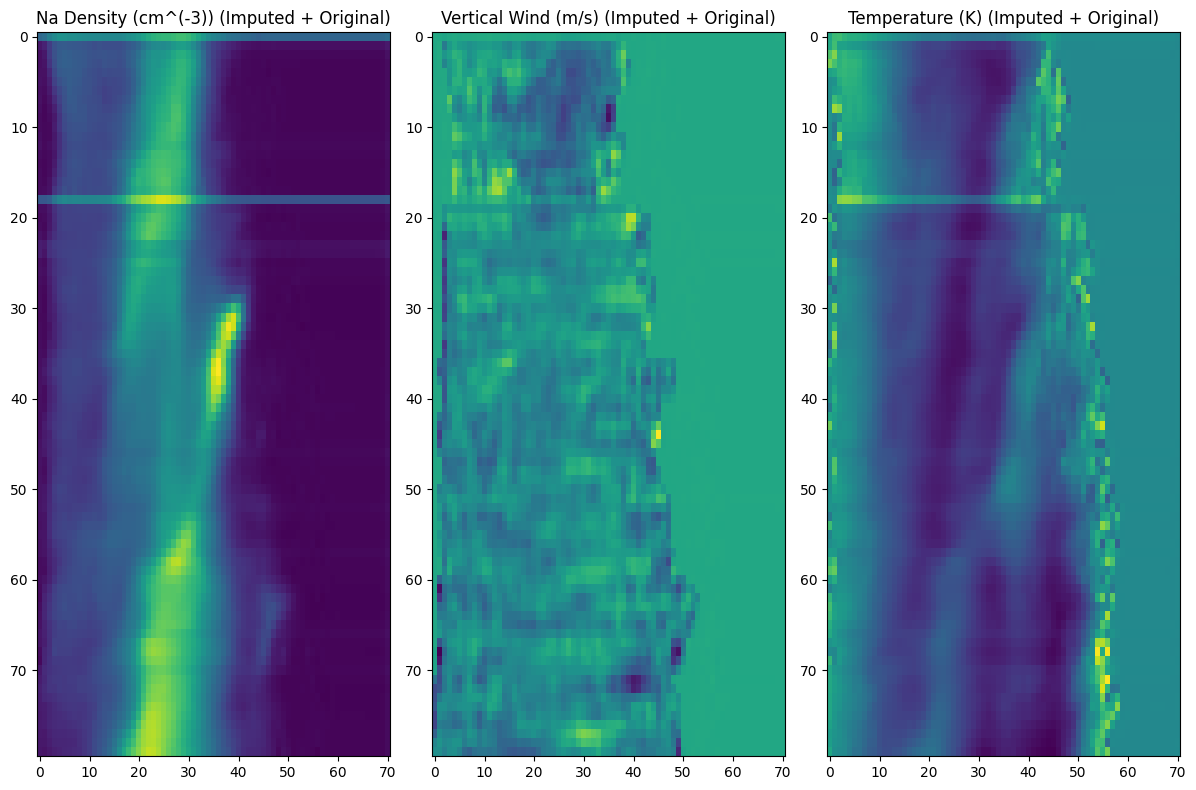

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


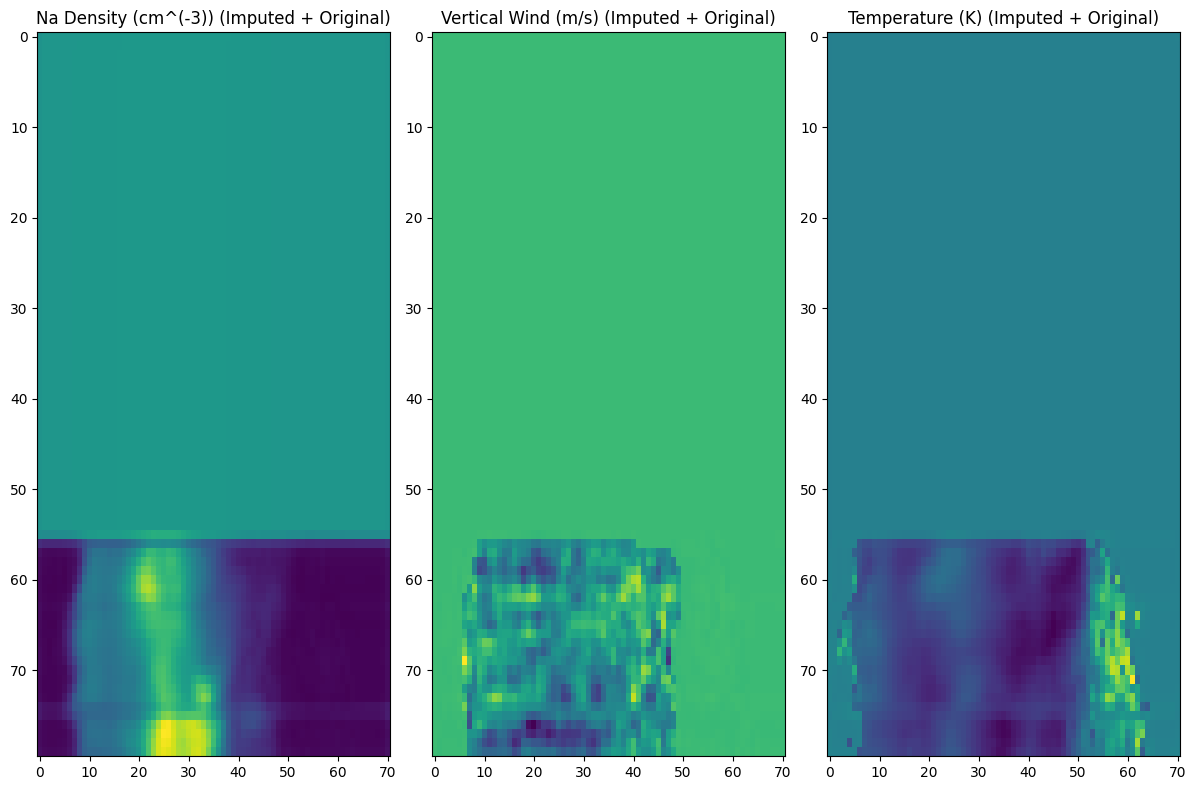

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 1.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 1.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


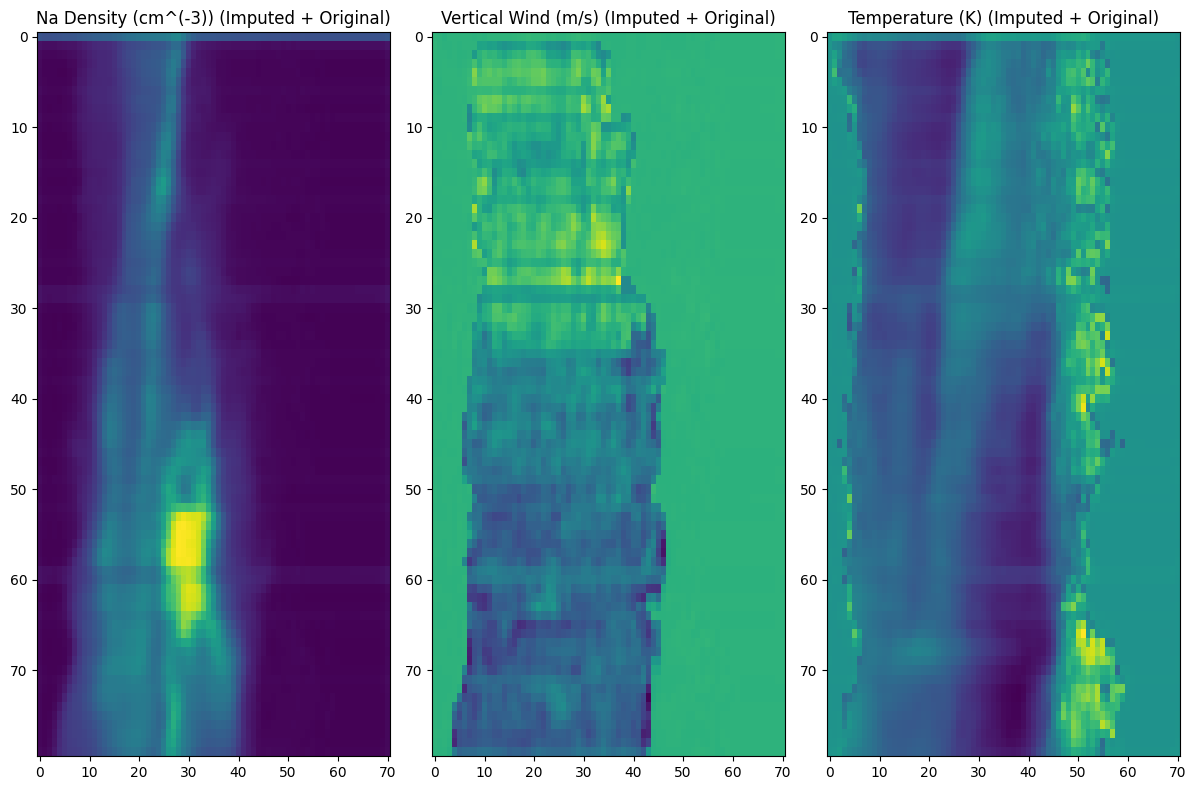

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 1.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 1.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


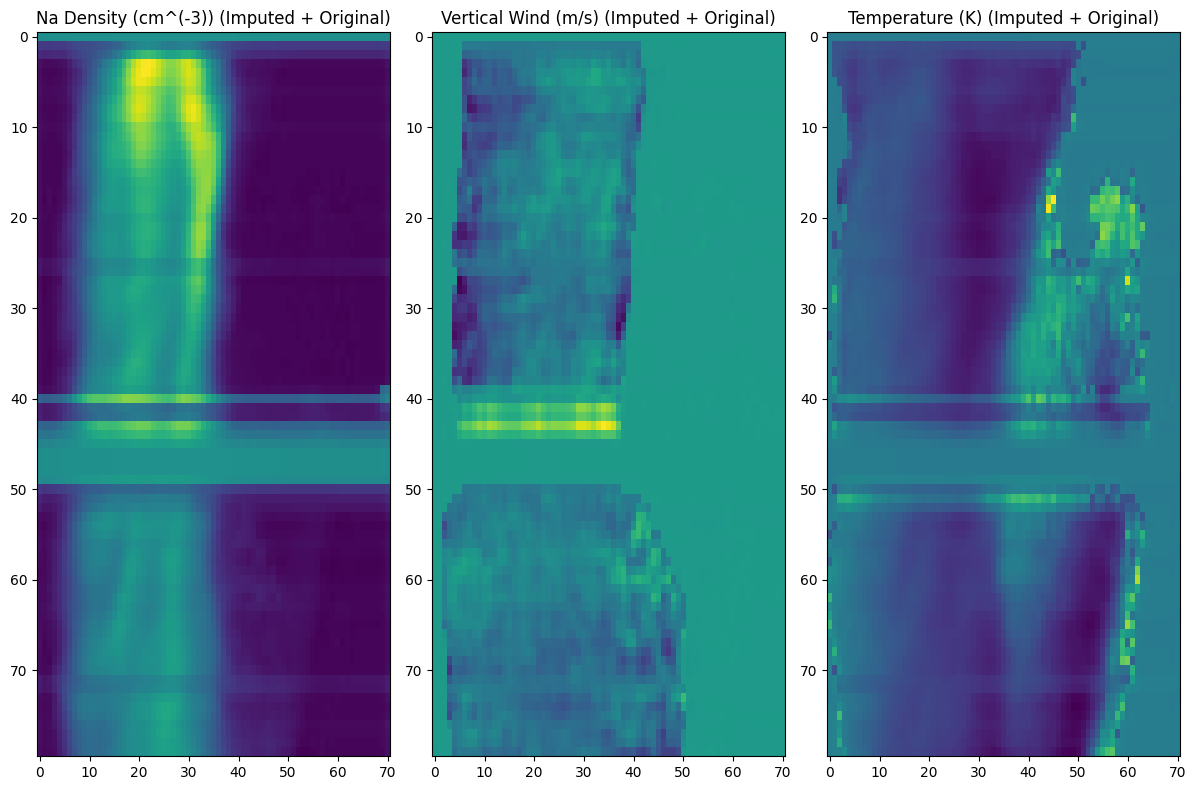

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]


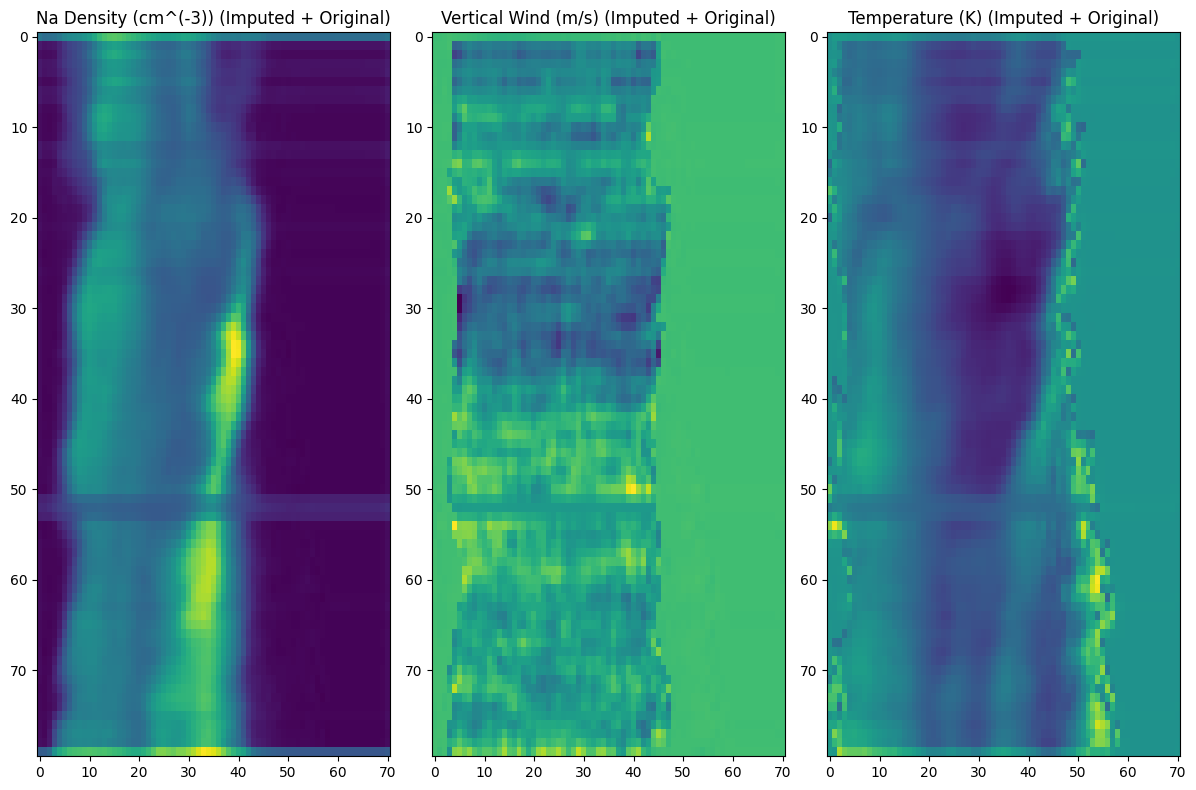

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [0. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


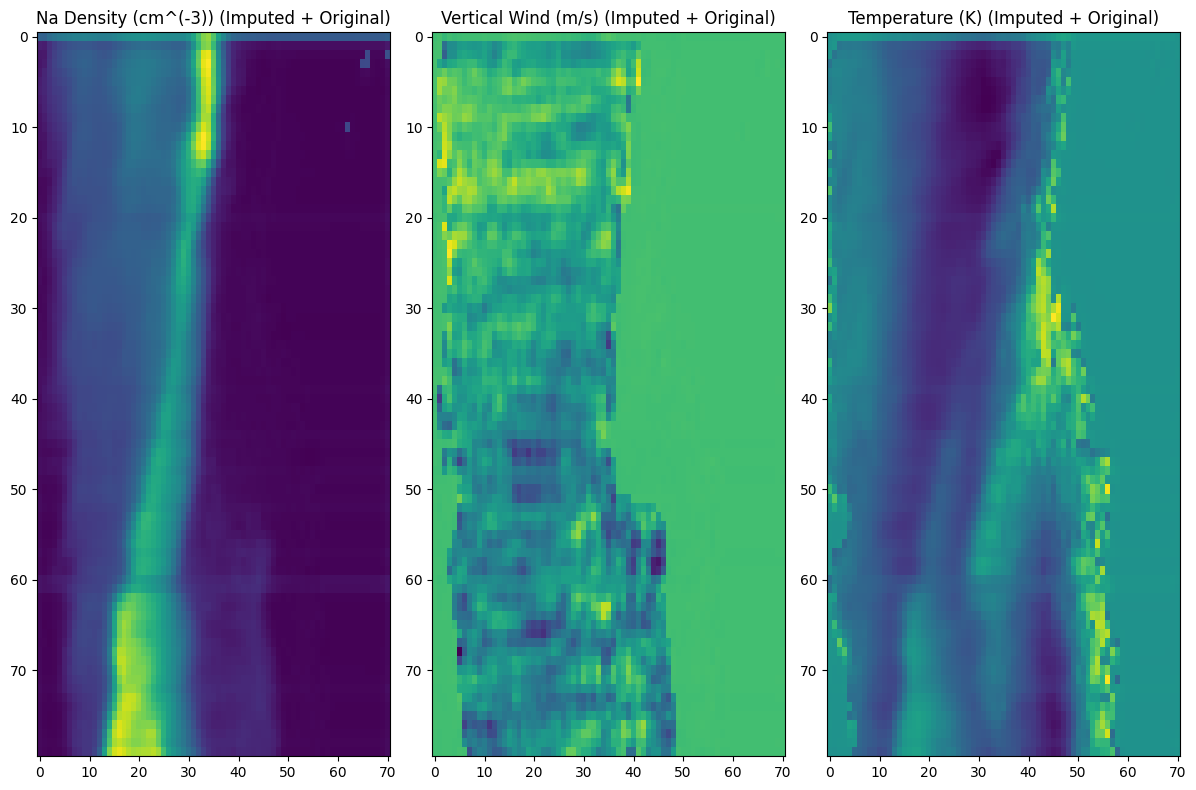

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


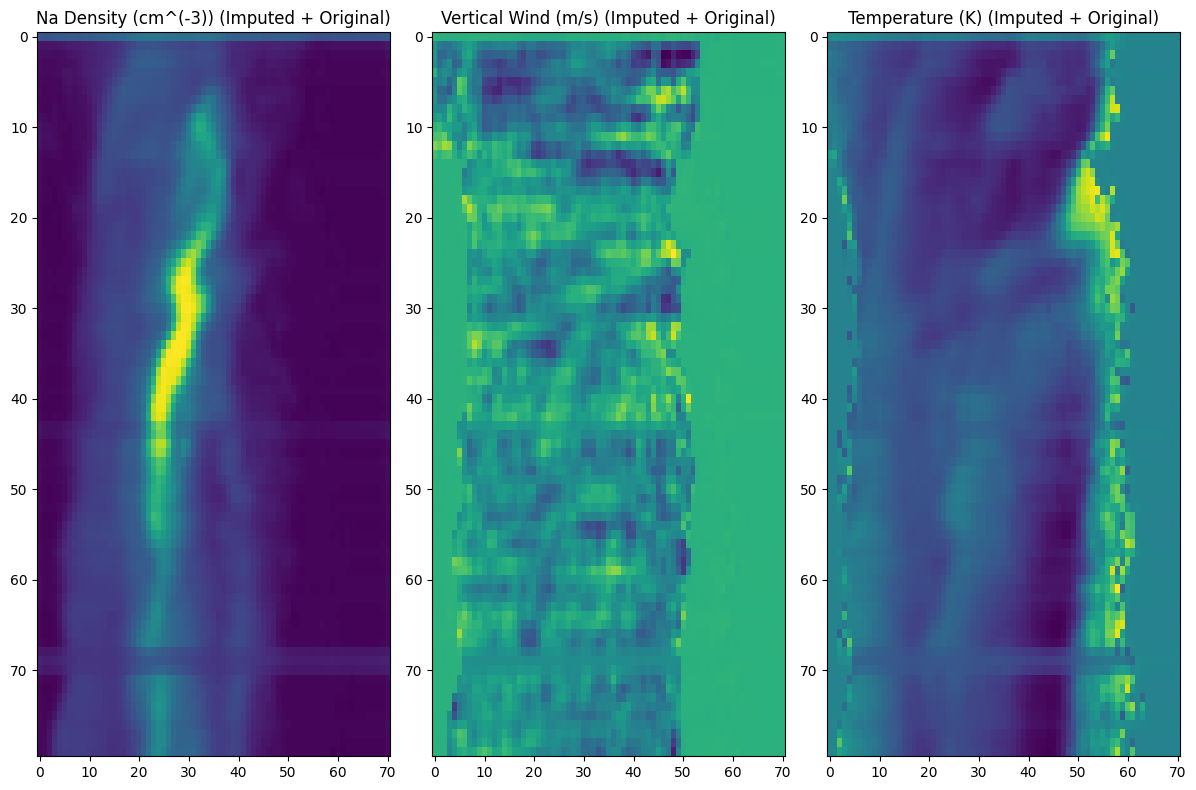

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


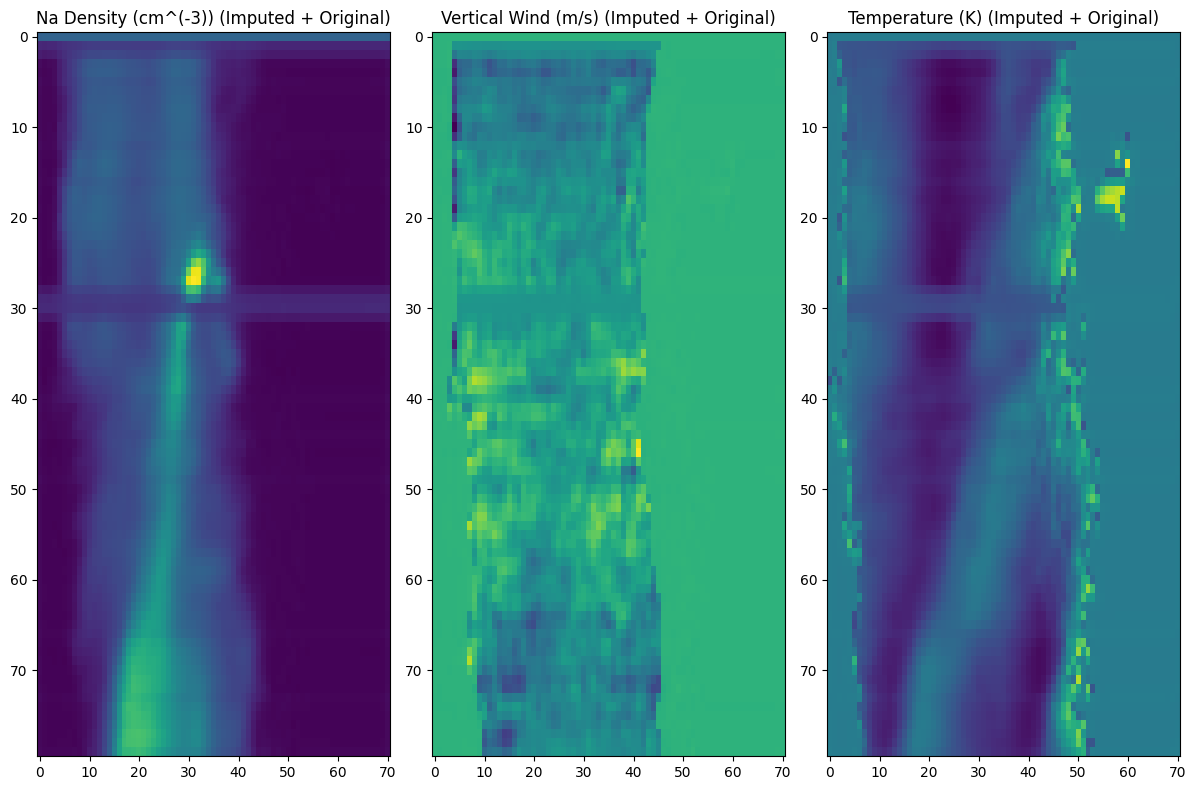

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


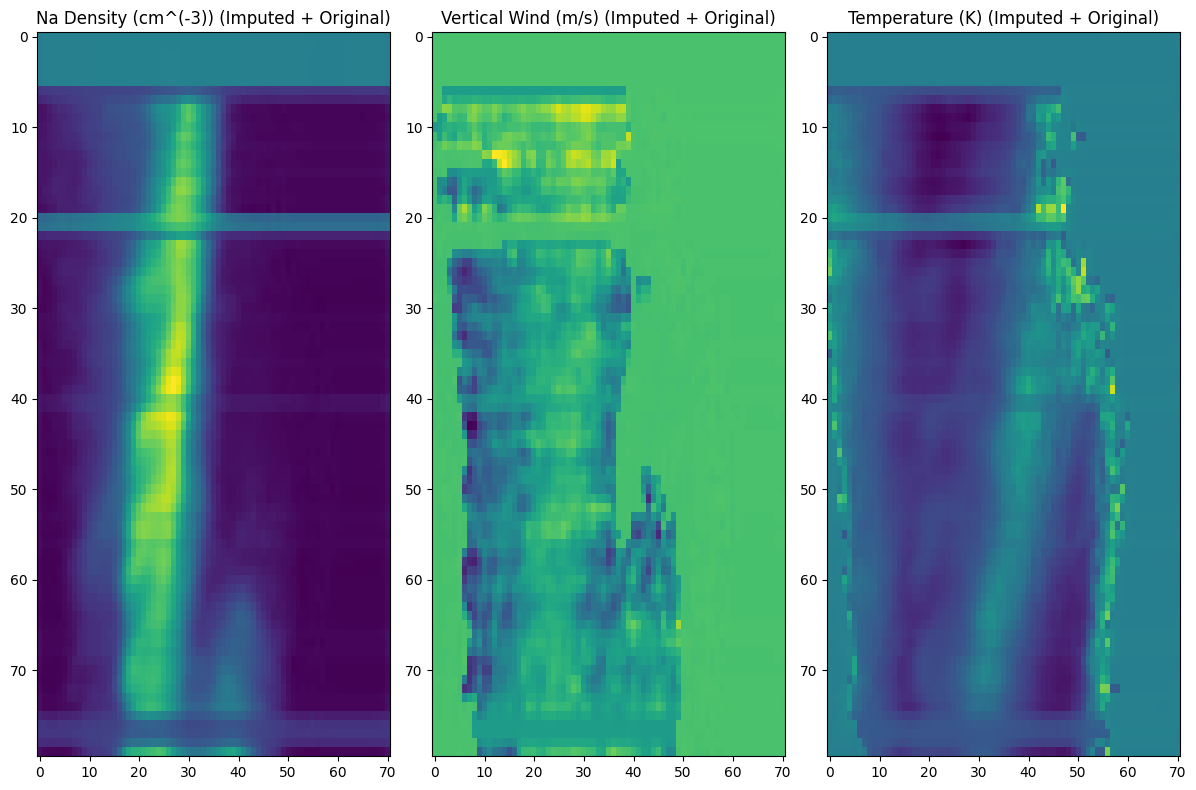

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]


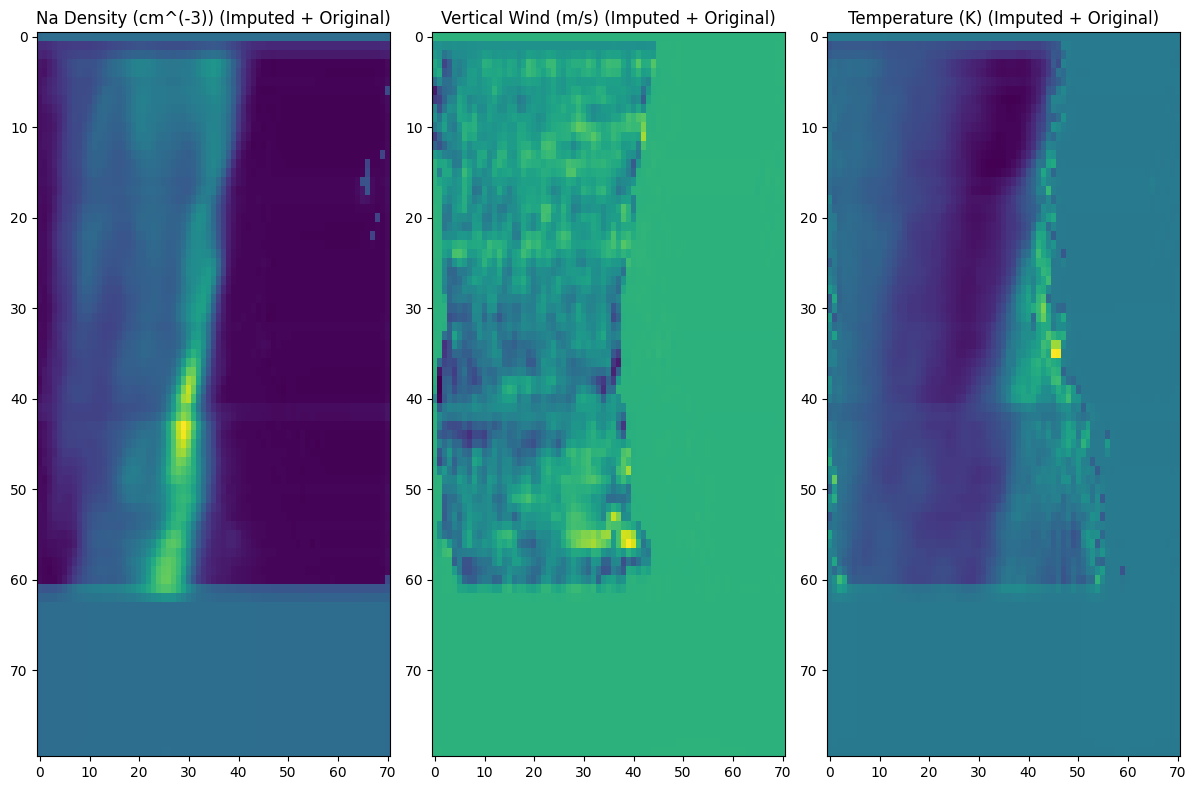

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


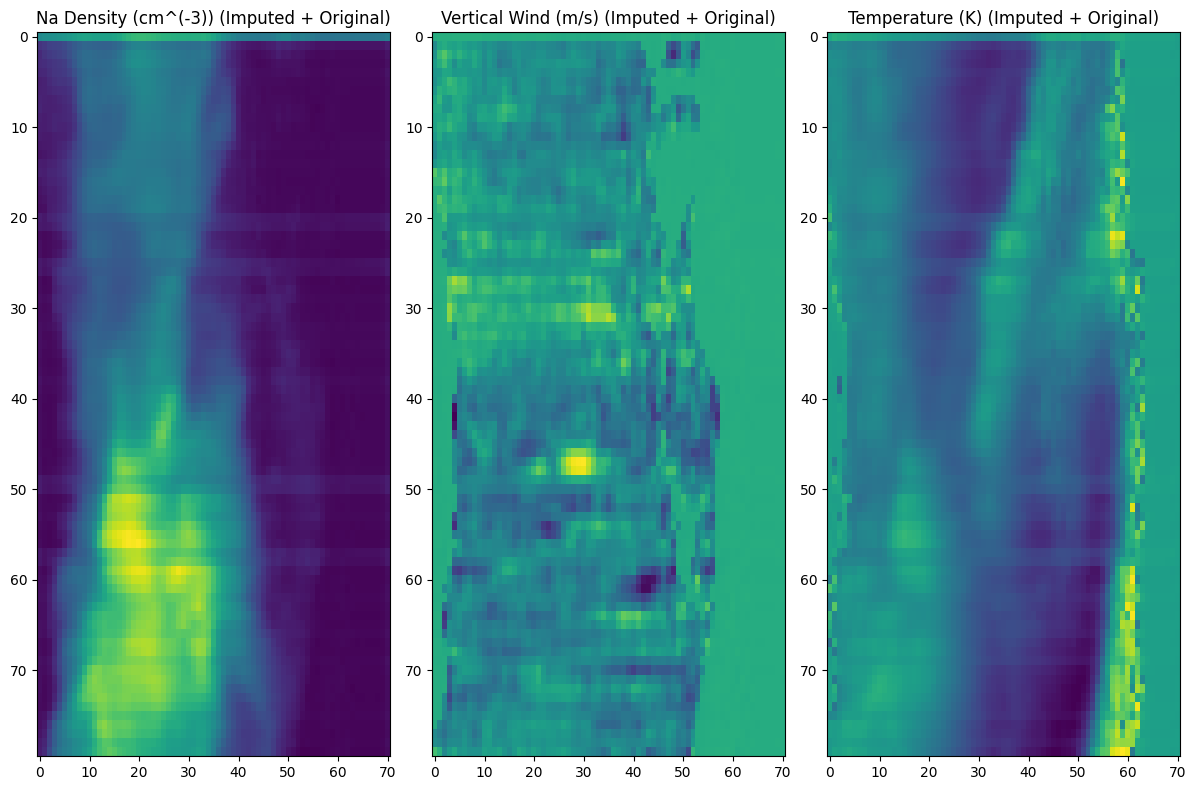

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


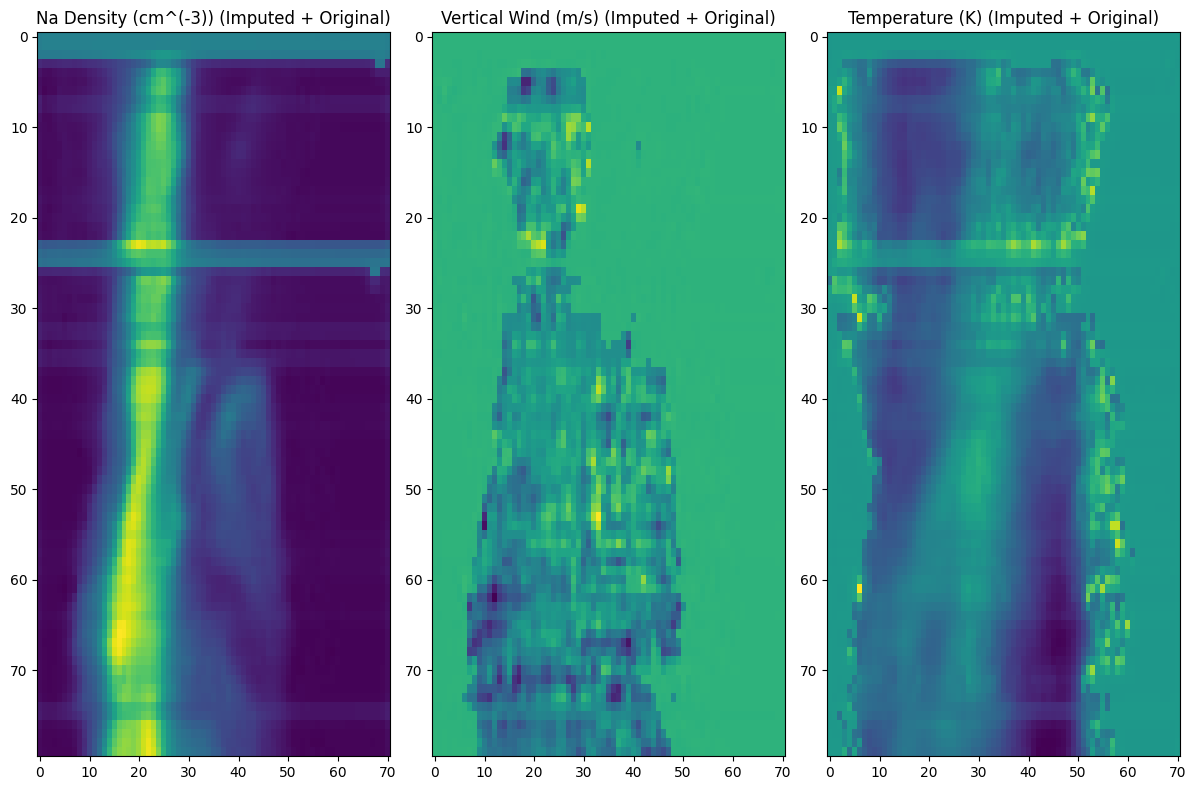

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 0. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 1.]
   [1. 0. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 1.]
   [1. 0. 0.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 1.]
   [1. 0. 0.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


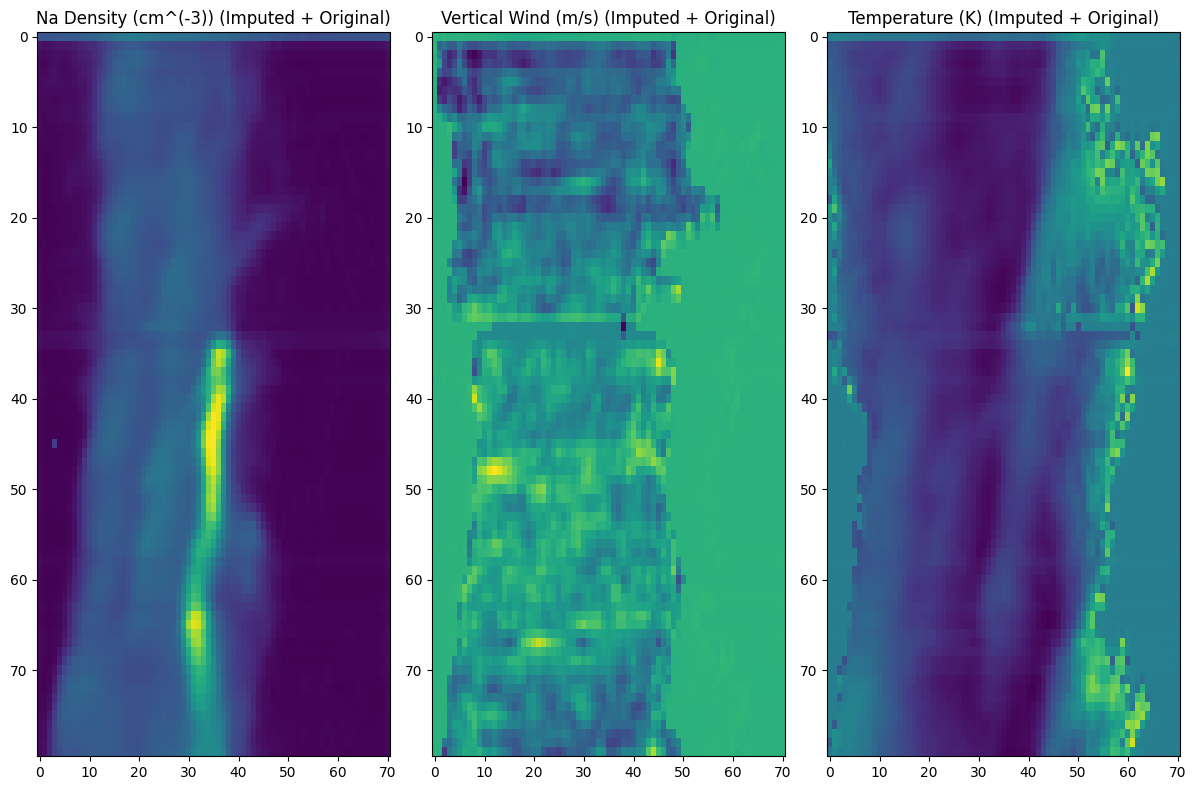

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 0. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]


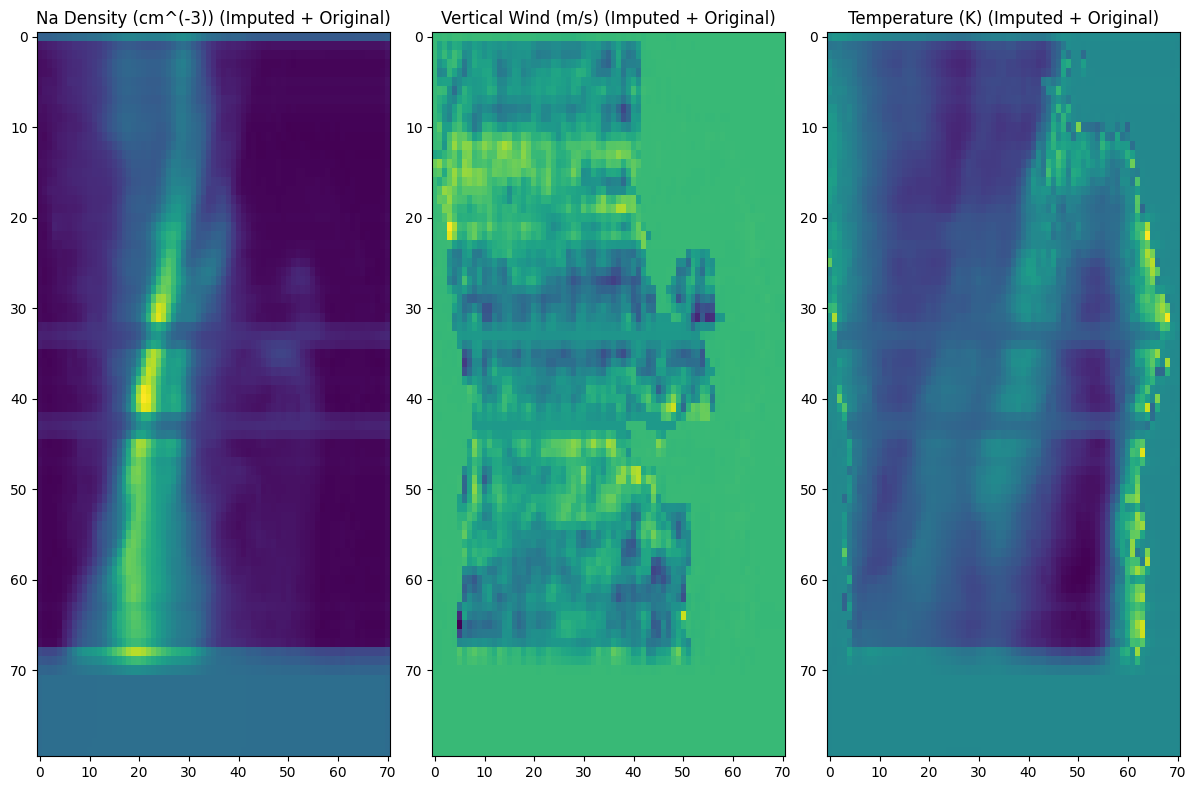

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


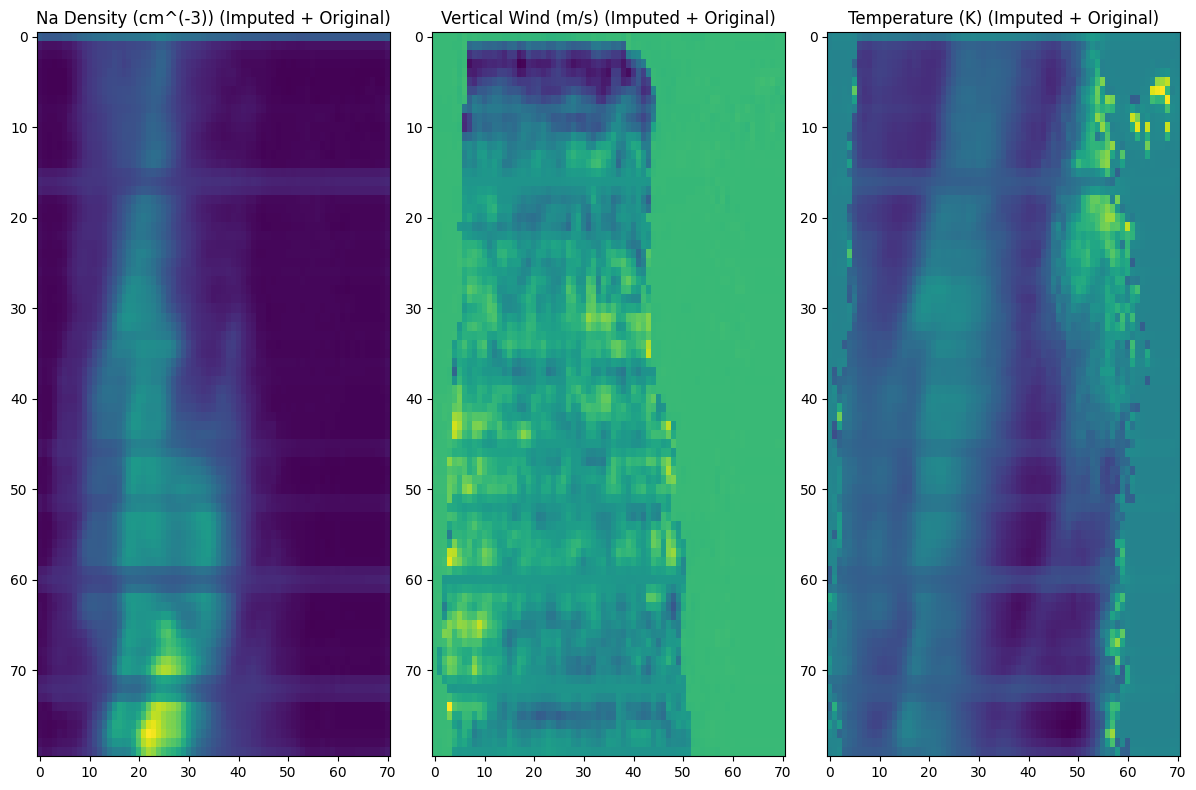

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


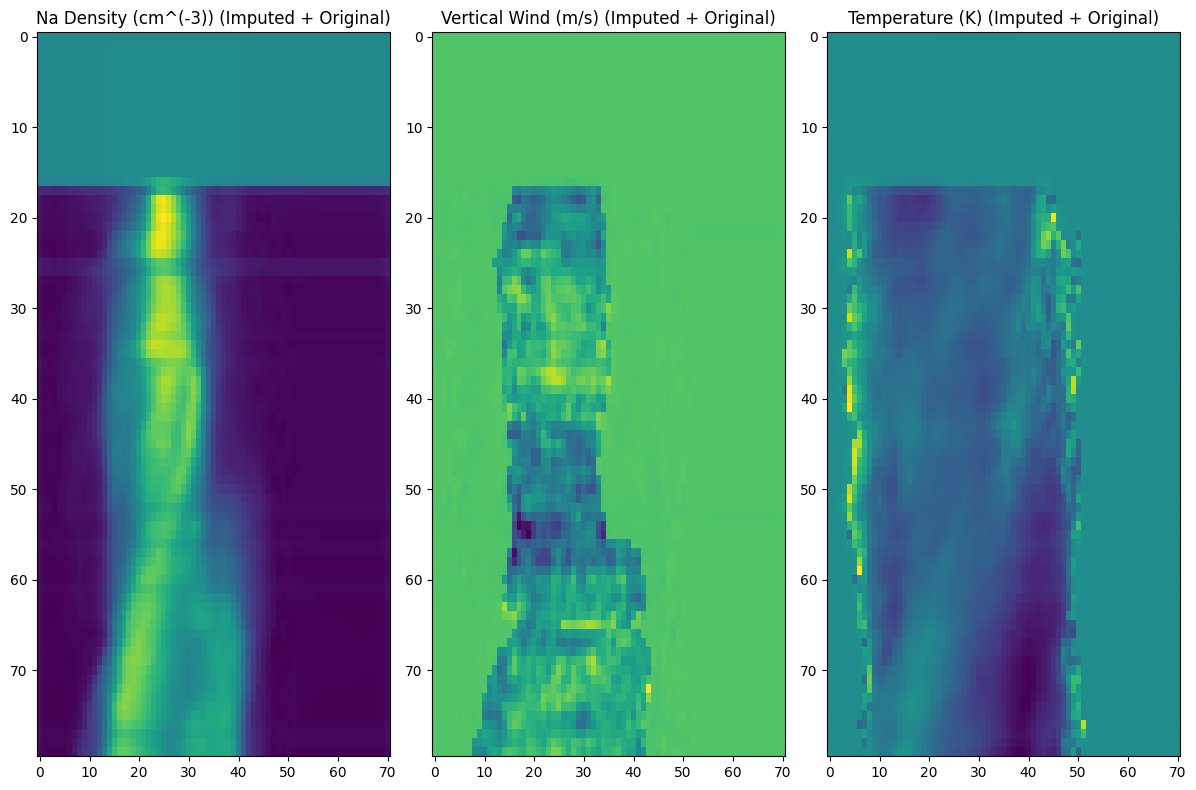

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


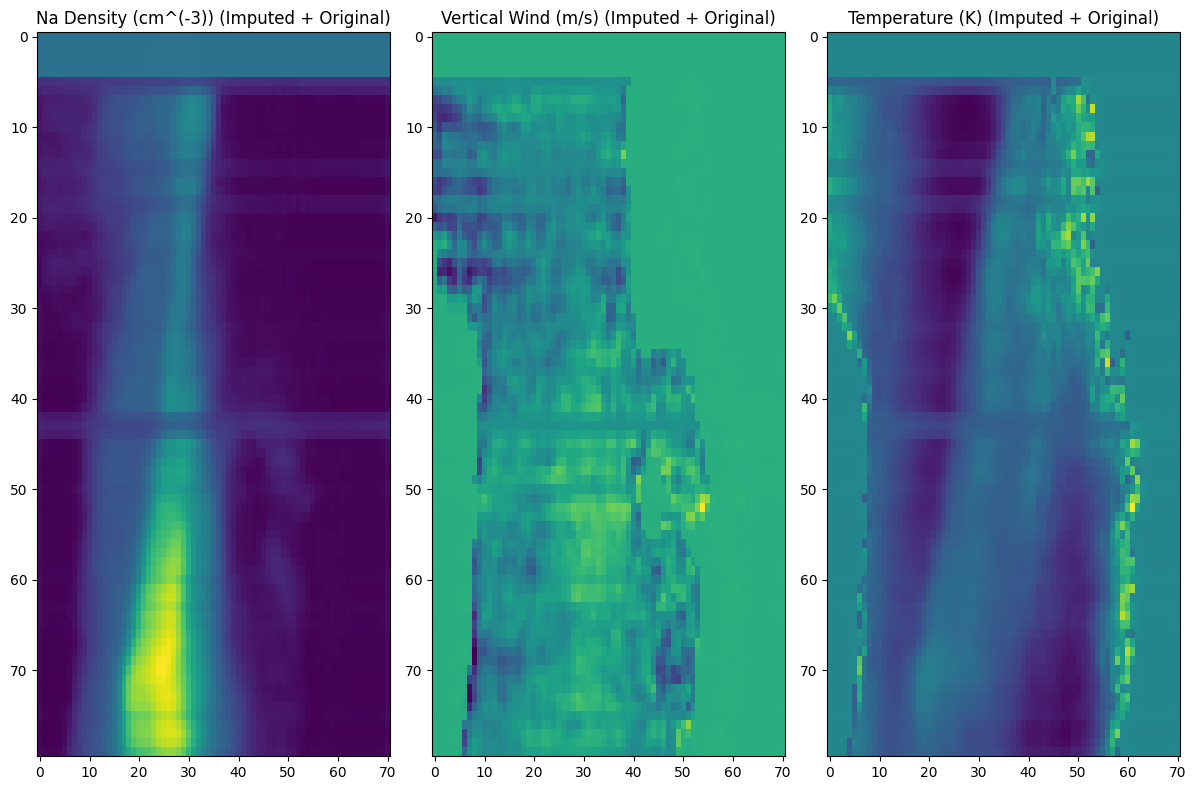

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


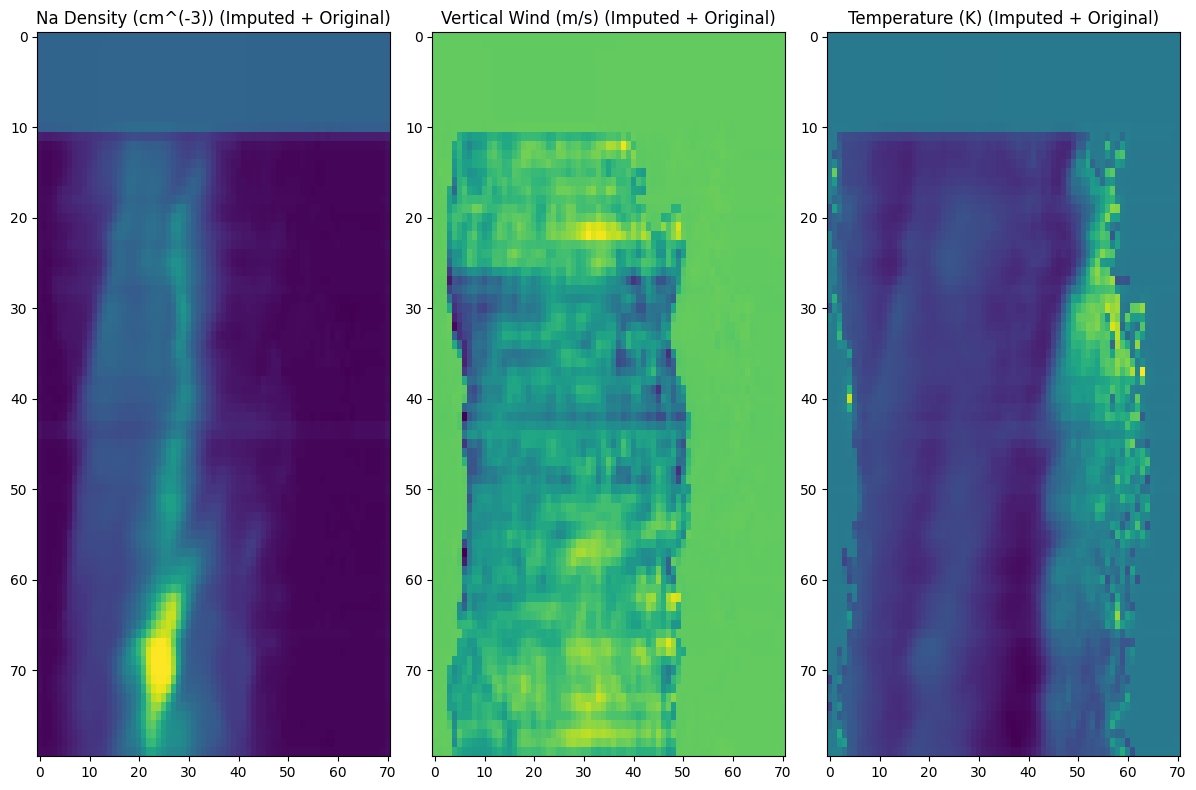

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  ...

  [[1. 0. 1.]
   [1. 0. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]]


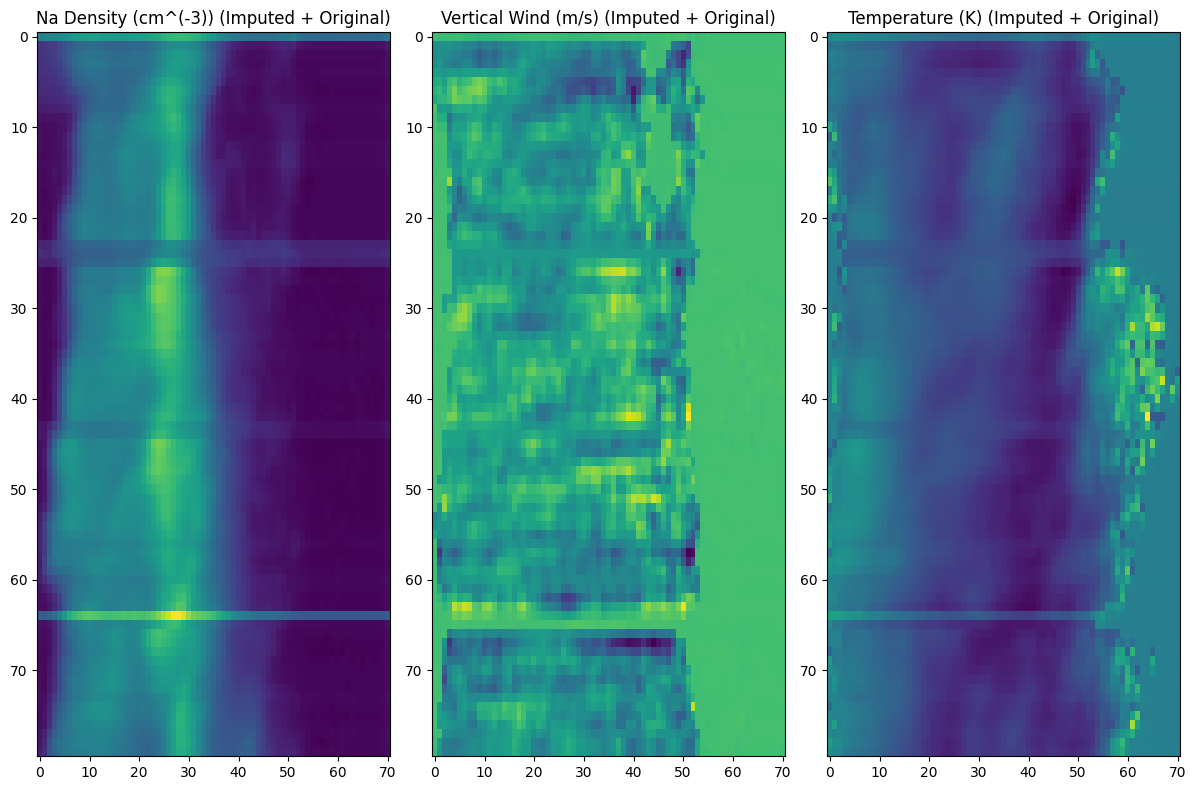

In [3]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import sys
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Paths to custom modules
sys.path.append(os.path.expanduser('/Users/huj7/Desktop/ERAU/MVI-2D/transformer'))

# Import necessary components
from NNstruct_v9 import mask_slices, MultivariableLocalTransformerWithChannelMixer, extract_local_window, restore_output_to_original_shape

# Model configuration
batch_size = 16
time_steps = 80
altitude_levels = 71
input_dim = 3   # Sodium density, wind, and temperature are 3-dimensional inputs
d_model = 64    # Reduced embedding dimension
nhead = 8       # Attention heads
num_layers = 4  # Transformer layers
dim_feedforward = 256  # Feedforward layer size
num_epochs = 300  # Number of epochs
window_size = 3
mask_ratio = 0.8  # Adjusted to prevent excessive masking
step_size = 1
base_weight = 1
lambda_smooth = 1

# Define device (CPU or CUDA)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model for multivariable inputs
model = MultivariableLocalTransformerWithChannelMixer(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    window_size=window_size  # Assuming a 3x3 local window
).to(device)

# Load the trained model weights
state_dict = torch.load('/Users/huj7/Desktop/ERAU/MVI-2D/Results/newrun/10_10_24/model_epoch_294.pth')
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

# Improved function for multivariable imputation with the updated changes
def impute_multivariable_data_local_window(model, data_dir, train_files, start_UT, end_UT, variables, device, mask_ratio):
    # Create scalers for each variable

    # Iterate over each training file
    for filename in train_files:
        daily_data = load_daily_data(data_dir, [filename], start_UT, end_UT)

        # Combine all variables (e.g., sodium density, wind, temperature)
        all_data = np.stack([np.transpose(np.stack(daily_data[var])) for var in variables], axis=-1)
        original_data = all_data.copy()
        scalers = {var: StandardScaler() for var in variables}
        # Normalize each variable independently, fitting the scaler only on non-missing data
        for var_idx, var in enumerate(variables):
            var_data = all_data[..., var_idx].reshape(-1, 1)  # Flatten the variable data
            scaled_var_data = scalers[var].fit_transform(var_data).reshape(all_data.shape[:-1]) 
            all_data[..., var_idx] = scaled_var_data

        # Convert to torch tensors and move to device
        train_data = torch.tensor(all_data, dtype=torch.float32).to(device)
        train_data = train_data.unsqueeze(0)  # Add batch dimension

        # Create mask for missing values
        mask_train = torch.isnan(train_data).float().to(device)
        mask_train = 1.0 - mask_train
        train_data = torch.nan_to_num(train_data, nan=0.0).to(device)
        target_data = train_data.clone()

        train_dataset = TensorDataset(train_data, target_data, mask_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for batch_idx, (batch_data, batch_target, batch_mask) in enumerate(train_loader):
            batch_data, batch_target, batch_mask = batch_data.to(device), batch_target.to(device), batch_mask.to(device)

            # Improved masking with realistic clustering and lower mask ratio
            masked_data, random_mask = mask_slices(batch_data, mask_ratio=mask_ratio)
            random_mask = random_mask.unsqueeze(-1)  # Add an extra dimension to match [1, 80, 71, input_dim]

            # Imputation using the model
            with torch.no_grad():
                local_windows, local_masks = extract_local_window(masked_data, random_mask, window_size, step_size)
                imputed_output = model(local_windows)

                # Restore imputed data to original shape using weighted restoration
                restored_data = restore_output_to_original_shape(
                    imputed_output,
                    orig_batch_size=batch_data.shape[0],  # Dynamically assign batch size
                    time_steps=time_steps,
                    altitude_levels=altitude_levels,
                    window_size=window_size,
                    step_size=step_size
                )

            # Combine imputed and original data
            mask_train_np = mask_train.cpu().numpy()  # Still using numpy for mask
            imputed_rescaled_no_nan = np.nan_to_num(restored_data.cpu().numpy(), nan=0.0)
            final_output = imputed_rescaled_no_nan # Combine with original data if necessary

            # Plot the final imputed data for each variable
            fig, axs = plt.subplots(1, len(variables), figsize=(12, 8))
            for var_idx, var in enumerate(variables):
                # Remove any extra dimensions (e.g., batch dimension) before plotting
                data_to_plot = np.squeeze(final_output[..., var_idx])
                axs[var_idx].imshow(data_to_plot, aspect='auto', cmap='viridis')
                axs[var_idx].set_title(f'{var} (Imputed + Original)')
            plt.tight_layout()
            plt.show()

    return final_output

# Run imputation for multiple variables (e.g., Sodium Density, Vertical Wind, Temperature)
variables = ["Na Density (cm^(-3))", "Vertical Wind (m/s)", "Temperature (K)"]
imputed_test_data = impute_multivariable_data_local_window(model, data_dir, train_files, start_UT, end_UT, variables, device, mask_ratio=0.8)
